In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 856.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import os
import shutil
from pathlib import Path
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import ultralytics
import zipfile

In [ ]:
from ultralytics import YOLO

In [ ]:
print("Library berhasil diimpor.")
print(f"Versi Ultralytics: {ultralytics.__version__}")

Library berhasil diimpor.
Versi Ultralytics: 8.3.145


In [ ]:
model = YOLO('yolov8n-cls.pt')

In [ ]:
zip_file_path = Path('brain_tumor_mri_dataset.zip')
temp_extract_base = Path('temp_extracted_dataset')

In [ ]:
if zip_file_path.exists():
    if not temp_extract_base.exists():
        print(f"Mengekstrak {zip_file_path} ke {temp_extract_base}...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_extract_base)
        print("Ekstraksi selesai.")
    else:
        print(f"Direktori '{temp_extract_base}' sudah ada. Melewatkan ekstraksi.")
else:
    print(f"File ZIP '{zip_file_path}' tidak ditemukan. Pastikan Anda telah mengunggahnya.")

Direktori 'temp_extracted_dataset' sudah ada. Melewatkan ekstraksi.


In [ ]:
data_dir = None
if temp_extract_base.exists():
    extracted_contents = list(temp_extract_base.iterdir())
    if len(extracted_contents) == 1 and extracted_contents[0].is_dir():
        data_dir = extracted_contents[0] # Jika ada satu subfolder, itu adalah root dataset
        print(f"Dataset root terdeteksi di subdirektori: {data_dir}")
    else:
        data_dir = temp_extract_base # Jika tidak, direktori ekstraksi itu sendiri adalah root
        print(f"Dataset root terdeteksi di direktori ekstraksi: {data_dir}")
else:
    print("Peringatan: Direktori ekstraksi sementara tidak ditemukan. Tidak dapat menentukan data_dir.")

Dataset root terdeteksi di subdirektori: temp_extracted_dataset/brain_tumor_mri_dataset


In [ ]:
original_train_dir = data_dir / 'Training' if data_dir else Path('')
original_test_dir = data_dir / 'Testing' if data_dir else Path('')

In [ ]:
yolo_data_root = Path('yolov8_brain_tumor_data')
yolo_train_dir = yolo_data_root / 'train'
yolo_val_dir = yolo_data_root / 'val'
yolo_test_dir = yolo_data_root / 'test'

In [ ]:
for d in [yolo_train_dir, yolo_val_dir, yolo_test_dir]:
    d.mkdir(parents=True, exist_ok=True)

In [ ]:
print(f"Data pelatihan asli: {original_train_dir}")
print(f"Data pengujian asli: {original_test_dir}")
print(f"Root data terstruktur YOLOv8: {yolo_data_root}")

Data pelatihan asli: temp_extracted_dataset/brain_tumor_mri_dataset/Training
Data pengujian asli: temp_extracted_dataset/brain_tumor_mri_dataset/Testing
Root data terstruktur YOLOv8: yolov8_brain_tumor_data


In [ ]:
if not original_train_dir.exists():
    print(f"Error: Direktori pelatihan asli tidak ditemukan di {original_train_dir}. Pastikan ekstraksi berhasil dan struktur folder benar.")
    class_names = [] # Set kosong untuk mencegah error lebih lanjut
else:
    class_names = sorted([d.name for d in original_train_dir.iterdir() if d.is_dir()])
print(f"Nama kelas yang terdeteksi: {class_names}")

Nama kelas yang terdeteksi: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
def copy_and_split_data(source_dir, train_dest, val_dest, test_dest, val_split=0.2, test_split_from_train=0.0):
    """
    Menyalin gambar dari source_dir ke train_dest, val_dest, dan test_dest
    berdasarkan pembagian yang ditentukan.
    """
    if not source_dir.exists():
        print(f"Peringatan: Direktori sumber '{source_dir}' tidak ditemukan. Melewatkan penyalinan data.")
        return

    print(f"\nMemproses direktori: {source_dir}")
    for class_name in class_names:
        class_source_path = source_dir / class_name
        if not class_source_path.exists():
            print(f"Peringatan: Direktori kelas '{class_source_path}' tidak ditemukan. Melewatkan kelas ini.")
            continue

        images = list(class_source_path.glob('*.jpg')) + list(class_source_path.glob('*.jpeg')) + list(class_source_path.glob('*.png'))
        random.shuffle(images) # Acak gambar untuk pembagian acak

        num_images = len(images)
        num_val = int(num_images * val_split)
        num_test_from_train = int(num_images * test_split_from_train) # Untuk membagi pengujian dari pelatihan asli jika diperlukan

        # Bagi menjadi pelatihan, validasi, dan berpotensi pengujian (jika membagi dari pelatihan asli)
        val_images = images[:num_val]
        test_images_from_train = images[num_val : num_val + num_test_from_train]
        train_images = images[num_val + num_test_from_train:]

        print(f"    Kelas: {class_name}")
        print(f"    Total gambar: {num_images}")
        print(f"    Gambar pelatihan: {len(train_images)}")
        print(f"    Gambar validasi: {len(val_images)}")
        print(f"    Gambar pengujian (dari pelatihan): {len(test_images_from_train)}")
        print("\n")


        # Salin ke direktori tujuan
        for img_path in train_images:
            (train_dest / class_name).mkdir(parents=True, exist_ok=True)
            shutil.copy(img_path, train_dest / class_name / img_path.name)
        for img_path in val_images:
            (val_dest / class_name).mkdir(parents=True, exist_ok=True)
            shutil.copy(img_path, val_dest / class_name / img_path.name)
        for img_path in test_images_from_train:
            (test_dest / class_name).mkdir(parents=True, exist_ok=True)
            shutil.copy(img_path, test_dest / class_name / img_path.name)

In [ ]:
if yolo_data_root.exists():
    print(f"Menghapus data yang ada di {yolo_data_root}...")
    shutil.rmtree(yolo_data_root)
    yolo_data_root.mkdir(parents=True, exist_ok=True)
    for d in [yolo_train_dir, yolo_val_dir, yolo_test_dir]:
        d.mkdir(parents=True, exist_ok=True)

Menghapus data yang ada di yolov8_brain_tumor_data...


In [ ]:
copy_and_split_data(original_train_dir, yolo_train_dir, yolo_val_dir, yolo_test_dir, val_split=0.2, test_split_from_train=0.0)


Memproses direktori: temp_extracted_dataset/brain_tumor_mri_dataset/Training
    Kelas: glioma
    Total gambar: 1321
    Gambar pelatihan: 1057
    Gambar validasi: 264
    Gambar pengujian (dari pelatihan): 0


    Kelas: meningioma
    Total gambar: 1339
    Gambar pelatihan: 1072
    Gambar validasi: 267
    Gambar pengujian (dari pelatihan): 0


    Kelas: notumor
    Total gambar: 1595
    Gambar pelatihan: 1276
    Gambar validasi: 319
    Gambar pengujian (dari pelatihan): 0


    Kelas: pituitary
    Total gambar: 1457
    Gambar pelatihan: 1166
    Gambar validasi: 291
    Gambar pengujian (dari pelatihan): 0




In [ ]:
print(f"\nMenyalin data pengujian asli dari {original_test_dir} ke {yolo_test_dir}")
for class_name in class_names:
    class_source_path = original_test_dir / class_name
    if not class_source_path.exists():
        print(f"Peringatan: Direktori kelas pengujian '{class_source_path}' tidak ditemukan. Melewatkan kelas ini.")
        continue
    images = list(class_source_path.glob('*.jpg')) + list(class_source_path.glob('*.jpeg')) + list(class_source_path.glob('*.png'))
    for img_path in images:
        (yolo_test_dir / class_name).mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, yolo_test_dir / class_name / img_path.name)
    print(f"  Menyalin {len(images)} gambar untuk kelas '{class_name}' ke set pengujian.")

print("\nPersiapan dataset selesai.")


Menyalin data pengujian asli dari temp_extracted_dataset/brain_tumor_mri_dataset/Testing ke yolov8_brain_tumor_data/test
  Menyalin 300 gambar untuk kelas 'glioma' ke set pengujian.
  Menyalin 306 gambar untuk kelas 'meningioma' ke set pengujian.
  Menyalin 405 gambar untuk kelas 'notumor' ke set pengujian.
  Menyalin 300 gambar untuk kelas 'pituitary' ke set pengujian.

Persiapan dataset selesai.


In [ ]:
print("\nVerifikasi struktur dataset akhir:")
for split_dir in [yolo_train_dir, yolo_val_dir, yolo_test_dir]:
    print(f"  Set {split_dir.name.capitalize()}:")
    for class_name in class_names:
        class_path = split_dir / class_name
        if class_path.exists():
            count = len(list(class_path.iterdir()))
            print(f"    {class_name}: {count} gambar")
        else:
            print(f"    {class_name}: 0 gambar (direktori tidak ditemukan)")


Verifikasi struktur dataset akhir:
  Set Train:
    glioma: 1057 gambar
    meningioma: 1072 gambar
    notumor: 1276 gambar
    pituitary: 1166 gambar
  Set Val:
    glioma: 264 gambar
    meningioma: 267 gambar
    notumor: 319 gambar
    pituitary: 291 gambar
  Set Test:
    glioma: 300 gambar
    meningioma: 306 gambar
    notumor: 405 gambar
    pituitary: 300 gambar


In [ ]:
results = model.train(
    data=str(yolo_data_root),
    epochs=20,
    imgsz=224,
    batch=32,
    dropout=0.2,
    name='brain_tumor_cls_model', # Nama untuk hasil train
)

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolov8_brain_tumor_data, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_cls_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

train: Scanning /content/yolov8_brain_tumor_data/train... 4571 images, 0 corrupt: 100%|██████████| 4571/4571 [00:02<00:00, 2192.69it/s]

train: New cache created: /content/yolov8_brain_tumor_data/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 204.4±70.5 MB/s, size: 22.9 KB)


val: Scanning /content/yolov8_brain_tumor_data/val... 1141 images, 0 corrupt: 100%|██████████| 1141/1141 [00:00<00:00, 3281.85it/s]

val: New cache created: /content/yolov8_brain_tumor_data/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/brain_tumor_cls_model
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20         0G      1.454         32        224:   1%|          | 1/143 [00:05<13:57,  5.90s/it]

       1/20         0G      1.421         32        224:   1%|▏         | 2/143 [00:08<09:20,  3.97s/it]
  0%|          | 0.00/755k [00:00<?, ?B/s]
100%|██████████| 755k/755k [00:00<00:00, 3.90MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:24<00:00,  1.34s/it]

                   all      0.893          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:23<00:00,  1.28s/it]

                   all      0.936          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

                   all      0.908          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]

                   all      0.926          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]

                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]

                   all      0.965          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]

                   all      0.917          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:23<00:00,  1.32s/it]

                   all      0.968          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]

                   all       0.97          1

      Epoch    GPU_mem       loss  Instances       Size



      10/20         0G    0.08913         27        224: 100%|██████████| 143/143 [03:51<00:00,  1.62s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

                   all      0.975          1

      Epoch    GPU_mem       loss  Instances       Size



      11/20         0G    0.07025         27        224: 100%|██████████| 143/143 [03:52<00:00,  1.63s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]

                   all      0.978          1

      Epoch    GPU_mem       loss  Instances       Size



      12/20         0G    0.07932         27        224: 100%|██████████| 143/143 [03:51<00:00,  1.62s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]

                   all      0.975          1

      Epoch    GPU_mem       loss  Instances       Size



      13/20         0G    0.07951         27        224: 100%|██████████| 143/143 [03:52<00:00,  1.63s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]

                   all      0.982          1

      Epoch    GPU_mem       loss  Instances       Size



      14/20         0G    0.07029         27        224: 100%|██████████| 143/143 [03:51<00:00,  1.62s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]

                   all      0.981          1

      Epoch    GPU_mem       loss  Instances       Size



      15/20         0G     0.0661         27        224: 100%|██████████| 143/143 [03:51<00:00,  1.62s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]

                   all       0.98          1

      Epoch    GPU_mem       loss  Instances       Size



      16/20         0G    0.06021         27        224: 100%|██████████| 143/143 [03:51<00:00,  1.62s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it]

                   all      0.982          1

      Epoch    GPU_mem       loss  Instances       Size



      17/20         0G    0.05118         27        224: 100%|██████████| 143/143 [03:52<00:00,  1.63s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]

                   all      0.983          1

      Epoch    GPU_mem       loss  Instances       Size



      18/20         0G    0.04977         27        224: 100%|██████████| 143/143 [03:54<00:00,  1.64s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]

                   all      0.985          1

      Epoch    GPU_mem       loss  Instances       Size



      19/20         0G    0.05192         27        224: 100%|██████████| 143/143 [03:50<00:00,  1.61s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]

                   all      0.985          1

      Epoch    GPU_mem       loss  Instances       Size



      20/20         0G    0.04245         27        224: 100%|██████████| 143/143 [03:59<00:00,  1.67s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:22<00:00,  1.25s/it]

                   all      0.989          1

20 epochs completed in 1.427 hours.
Optimizer stripped from runs/classify/brain_tumor_cls_model/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/brain_tumor_cls_model/weights/best.pt, 3.0MB

Validating runs/classify/brain_tumor_cls_model/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,440,004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolov8_brain_tumor_data/train... found 4571 images in 4 classes ✅ 
val: /content/yolov8_brain_tumor_data/val... found 1141 images in 4 classes ✅ 
test: /content/yolov8_brain_tumor_data/test... found 1311 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


                   all      0.989          1
Speed: 0.0ms preprocess, 12.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/brain_tumor_cls_model


In [ ]:
best_model_path = Path('runs/classify/brain_tumor_cls_model/weights/best.pt')
if not best_model_path.exists():
    print(f"Error: Model terbaik tidak ditemukan di {best_model_path}. Pastikan pelatihan selesai dengan sukses.")
else:
    trained_model = YOLO(str(best_model_path))
    print(f"Best trained model loaded from: {best_model_path}")

    # Evaluasi model pada set pengujian
    metrics = trained_model.val(data=str(yolo_data_root), imgsz=224) # Pastikan imgsz cocok dengan pelatihan

    print("\nHasil Evaluasi Model:")
    print(f"Akurasi Top-1: {metrics.top1:.4f}")
    print(f"Akurasi Top-5: {metrics.top5:.4f}")

Best trained model loaded from: runs/classify/brain_tumor_cls_model/weights/best.pt
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,440,004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolov8_brain_tumor_data/train... found 4571 images in 4 classes ✅ 
val: /content/yolov8_brain_tumor_data/val... found 1141 images in 4 classes ✅ 
test: /content/yolov8_brain_tumor_data/test... found 1311 images in 4 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 742.7±284.5 MB/s, size: 22.9 KB)


val: Scanning /content/yolov8_brain_tumor_data/val... 1141 images, 0 corrupt: 100%|██████████| 1141/1141 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 72/72 [00:18<00:00,  3.88it/s]


                   all      0.989          1
Speed: 0.0ms preprocess, 11.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val

Hasil Evaluasi Model:
Akurasi Top-1: 0.9886
Akurasi Top-5: 1.0000


In [ ]:
def predict_brain_tumor(image_path, model, class_names):
    """
    Memprediksi jenis tumor otak untuk gambar yang diberikan.

    Args:
        image_path (str atau Path): Jalur ke gambar input.
        model (YOLO): Model klasifikasi YOLOv8 yang telah dilatih.
        class_names (list): Daftar nama kelas dalam urutan yang sesuai dengan output model.

    Returns:
        tuple: (nama_kelas_prediksi, skor_kepercayaan)
    """
    if not Path(image_path).exists():
        print(f"Error: Gambar tidak ditemukan di {image_path}")
        return None, None

    print(f"\nMemprediksi untuk gambar: {image_path}")
    # Lakukan prediksi
    # Metode 'predict' mengembalikan daftar objek Hasil
    results = model.predict(source=str(image_path), imgsz=224, verbose=False) # Pastikan imgsz cocok dengan pelatihan

    if results:
        # Untuk klasifikasi, results[0].probs berisi probabilitas
        probs = results[0].probs
        if probs is not None:
            top_prob_index = probs.top1
            confidence = probs.top1conf.cpu().numpy() # Dapatkan kepercayaan sebagai array numpy
            predicted_class_name = class_names[top_prob_index]

            print(f"  Kelas Prediksi: {predicted_class_name}")
            print(f"  Kepercayaan: {confidence:.4f}")

            # Opsional: Tampilkan gambar dengan prediksi
            try:
                img = Image.open(image_path)
                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.title(f"Prediksi: {predicted_class_name} (Kepercayaan: {confidence:.2f})")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Tidak dapat menampilkan gambar: {e}")

            return predicted_class_name, confidence
        else:
            print("  Tidak ada probabilitas yang ditemukan dalam hasil prediksi.")
            return None, None
    else:
        print("  Tidak ada hasil prediksi yang diperoleh.")
        return None, None


Memprediksi untuk gambar: yolov8_brain_tumor_data/test/glioma/Te-gl_0170.jpg
  Kelas Prediksi: glioma
  Kepercayaan: 1.0000


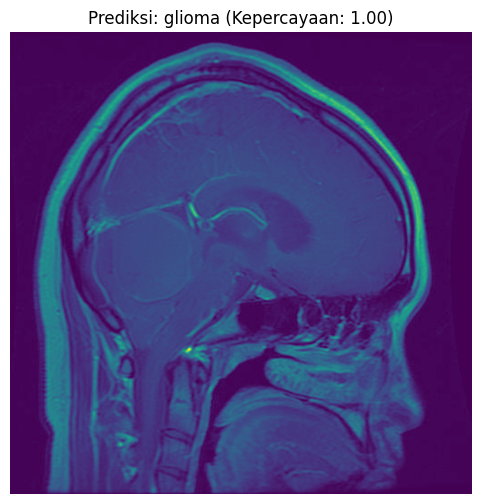


Hasil Prediksi Sampel: Gambar diklasifikasikan sebagai 'glioma' dengan kepercayaan 1.0000.


In [ ]:
if best_model_path.exists():
    # Muat model terbaik yang dilatih
    final_model = YOLO(str(best_model_path))

    # Pilih gambar acak dari set pengujian untuk demonstrasi
    sample_image_path = None
    for class_name in class_names:
        class_test_path = yolo_test_dir / class_name
        images = list(class_test_path.glob('*.jpg')) + list(class_test_path.glob('*.jpeg')) + list(class_test_path.glob('*.png'))
        if images:
            sample_image_path = random.choice(images)
            break # Menemukan contoh gambar, hentikan loop

    if sample_image_path:
        predicted_class, confidence = predict_brain_tumor(sample_image_path, final_model, class_names)
        if predicted_class:
            print(f"\nHasil Prediksi Sampel: Gambar diklasifikasikan sebagai '{predicted_class}' dengan kepercayaan {confidence:.4f}.")
    else:
        print("Tidak ada contoh gambar yang ditemukan di direktori pengujian untuk mendemonstrasikan prediksi.")
else:
    print("Tidak dapat melakukan prediksi karena model yang dilatih tidak ditemukan.")

In [ ]:
your_image_path = '/content/pituitary1.jpg'


Memprediksi untuk gambar: /content/pituitary1.jpg
  Kelas Prediksi: pituitary
  Kepercayaan: 0.9982


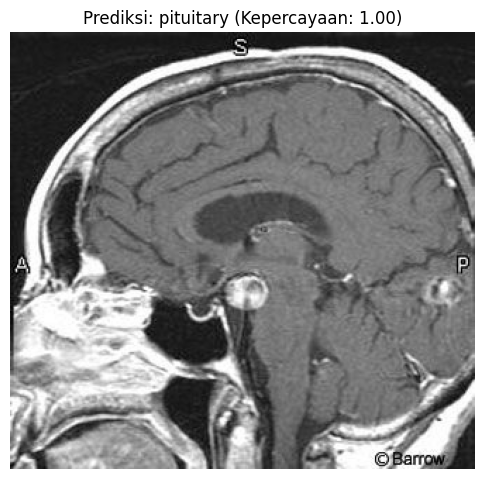


Prediksi Gambar Anda: Gambar '/content/pituitary1.jpg' diklasifikasikan sebagai 'pituitary' dengan kepercayaan 0.9982.


In [ ]:
if best_model_path.exists():
    final_model = YOLO(str(best_model_path))
    predicted_class, confidence = predict_brain_tumor(your_image_path, final_model, class_names)

    if predicted_class:
        print(f"\nPrediksi Gambar Anda: Gambar '{your_image_path}' diklasifikasikan sebagai '{predicted_class}' dengan kepercayaan {confidence:.4f}.")
    else:
        print(f"\nTidak dapat memprediksi untuk gambar: {your_image_path}. Harap periksa jalur dan pastikan gambar ada.")
else:
    print("Tidak dapat melakukan prediksi karena model yang dilatih tidak ditemukan. Pastikan pelatihan selesai dengan sukses.")